<h1> $X_{\pi/4}$ quantum gate </h1>

I start by writing a generic quantum control Hamiltonian, $\hat{H}(t) = \hat{H}_\text{drive}(t) + \hat{H}_\text{eff}(t)$, where 
\begin{equation}\label{hamiltonian}
\hat{H}_\text{drive}(t)=\sum_i f_i(t)\hat{K}_i, \quad \hat{H}_\text{eff}(t)=\sum_i\epsilon_i\omega_i(t)\hat{K}_i,
\end{equation}
$f_i$ are the driving fields, $\omega_i$ are stochastic processes weighted individually by the strengths $\epsilon_i$, and $\hat{K}_i$ are generic operators satisfying a Lie algebra $\mathfrak{su}(N)$ with the property $\text{Tr}(K_iK_j)=N\delta_{ij}$.

The effective Hamiltonian, $\hat{H}_\text{eff}$, can be treated as the component of interaction, with the time evolution:
\begin{equation}
\hat{U}(t)=\hat{U}_\text{eff}^\dagger(t)\hat{U}_\text{drive},
\end{equation}
where the driving and the effective evolution operators fulfil the ordinary equations:
\begin{equation}\label{evolution}
\frac{\mathrm{d}\hat{U}_\text{drive}(t)}{\mathrm{d}t} =  -i\hat{H}_\text{drive}(t)\hat{U}_\text{drive}(t) \quad \text{and} \quad \frac{\mathrm{d}\hat{U}_\text{eff}(t)}{\mathrm{d}t} =  -i\hat{U}^\dagger_\text{drive}(t)\hat{H}_\text{eff}(t)\hat{U}_\text{drive}(t),
\end{equation}
respectively. 

A robust QG needs of a minimum noise level during an operational time $T$,
such that the condition $\partial_{\epsilon_i}\hat{U}_\text{eff}(T)|_{\epsilon_i}=0$ is fulfilled. In turn, the effective evolution operator can be approximated as:
\begin{equation}\label{ueff}
U_\text{eff}(T)=\exp\left(-\frac{i}{\hbar}\sum_i \epsilon_i J_i(T)\right) + O(\epsilon_i^2),
\end{equation}
where
\begin{equation}\label{noise}
J_i(T)=\int_0^T\mathrm{d}t\,U_\text{drive}^\dagger(t)\omega_i(t)\hat{K}_i\hat{U}_\text{drive}(t).
\end{equation}

Problem. To optimise a cost function $C = C_1\left(\hat{U}_\text{drive}(t)\right) + C_2\left(\hat{U}_\text{drive}(t)\right)$, whose terms are 
\begin{equation}\begin{split}
C_1\left(\hat{U}_\text{drive}(t)\right) &= \chi\left[\text{Tr}\left(\hat{\rho}^2\right) - \left|\text{Tr}\left(\hat{\Pi}\hat{U}_\text{drive}(T)\hat{\Pi}^\dagger \hat{U}_\text{drive}(0)\right)\right|^m \right]\\
C_2\left(\hat{U}_\text{drive}(t)\right) &= \varphi\left[\text{Tr}\left(\hat{\rho}^2\right) - \frac{1}{N}\sum_i^N\left(\epsilon_i^*||\hat{\Pi}J_i(T)||\right)^n\right],
\end{split}\end{equation}
where $\hat{\Pi}$ is a projection operator, $\hat{\rho}$ is a density matrix, and the monotonically increasing functions $\chi$ and $\varphi$ are Kolmogorov-Nagumo functions–for most problems they typically are $\chi(x)=x$ and $\varphi(x)=x$.

The Hamiltonian for a transmon qubit in a rotating frame can be put into the approximated form of a nonlinear oscillator of dimension $d$:
\begin{equation}
\hat{H}(t)=\sum_{j=1}^{d-1}(\delta(t)+\Delta_j)\hat{\Pi}_j + \sum_{j=1}^{d-1}\frac{\Omega_x(t)\sigma^x_{j-1,j} + \Omega_y(t)\sigma^y_{j-1,j}}{2},
\end{equation}
where $\sigma^x_{j,k}= \vert k \rangle \langle j \vert + \vert j \rangle \langle k \vert$ and $\sigma^y_{j,k}= i \vert k \rangle \langle j \vert -i\vert j \rangle \langle k \vert$ with $j<k$, $\hat{\Pi}_j=\vert j \rangle \langle j \vert$ is a projection operator onto the $j$th state, $\Delta_j$ is the anharmonicity, $\delta(t)$ is the qubit detuning and $\Omega(t)=\Omega_x(t)+i\Omega_y(t)$ is the complex modulated amplitude of the microwave driving field.

The goal is to find a microwave amplitude $\Omega(t)$ and a detuning function $\delta(t)$ such that the cost function vanishes or, at least, becomes negligible. Upon successful computation, a robust QG can be claimed. 

<h2> Packages </h2>

In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using LinearAlgebra
using StaticArrays
using Flux
using Optim
# ----------------------------/
using ApproxFun
using SpecialFunctions
# ----------------------------/
using Plots
using PGFPlotsX
using PlotThemes
using PaddedViews
using LaTeXStrings
using BenchmarkTools
using Zygote
# ----------------------------/
using DiffEqFlux
using DiffEqSensitivity

In [2]:
pgfplotsx();
Plots.PGFPlotsXBackend();

In [3]:
const σ0 = Hermitian(Complex{Float64}[1 0; 0 1]);
const σx = Hermitian(Complex{Float64}[0 1; 1 0]);
const σy = Hermitian(Complex{Float64}[0 -im; im 0]);
const σz = Hermitian(Complex{Float64}[1 0; 0 -1]);

In [4]:
Ωp_nn = FastChain(FastDense(1,32), FastDense(32,32,tanh), FastDense(32,32,tanh), FastDense(32,6))
θ_transmon = initial_params(Ωp_nn);

<h2> Main algorithm </h2>

In [71]:
const tol = 1e-7;

const Δ = -2π*0.6;
const HΔ = 1*Hermitian(Complex{Float64}[0 0 0 0; 0 0 0 0; 0 0 Δ 0; 0 0 0 3Δ]);
const Hϵ = Δ*Hermitian(Complex{Float64}[0 0 0 0; 0 1 0 0; 0 0 2 0; 0 0 0 3]);

const T = 15.0;
tspan = (0.0, T);

const θ = -π/2;
const Utarget = (cos(θ/2)*σ0 + sin(θ/2)im*σx);
    
const steepness = 20*T
smooth_square_envelope(t) = coth(steepness/4)*( tanh(steepness*t/(4*T)) 
    - tanh(steepness*(t-T)/(4*T)) ) - 1;

function schrodinger_transmon_nn(u, p, t)
    @views @inbounds U = u[1:4, 1:4];
    @views @inbounds ℰ = u[5:8, 1:4];
    envelope = smooth_square_envelope(t);

    @views @inbounds nn_output = Ωp_nn([t/T],p);
    @inbounds Ωx, Ωy, δ = envelope*( nn_output[1]*sin(nn_output[2]) ), 
    envelope*(nn_output[3]*sin(nn_output[4]) ), envelope*nn_output[5]*sin(nn_output[6]) 
    Ω = Ωx - im*Ωy;
    Ωconj = Ωx + im*Ωy;
    @inbounds H = Hermitian([0 Ω 0 0; Ωconj δ √2*Ω 0; 0 √2*Ωconj (Δ+2δ) √3*Ω; 0 0 √3*Ωconj (3Δ+3δ)]);
    @inbounds local dℰ = U'*(Hϵ)*U;
    return [-(im)*(H)*U; dℰ]
end

const u0_transmon = Complex{Float64}[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1; 0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 0;];
ode_transmon_nn = ODEProblem(schrodinger_transmon_nn, u0_transmon, tspan, θ_transmon);

function callback(p, cost)
    return cost < 1e-6
end

function cost_adjoint_transmon_nn(p, w=1.0)
    local ode_sol = solve(ode_transmon_nn, BS5(), p=Complex{Float64}.(p), abstol=tol, reltol=tol);
    local usol = last(ode_sol);

    @views @inbounds local Ugate = usol[1:2, 1:2];
    @views @inbounds local ℰ = usol[5:6, 1:2];
    @views @inbounds local ℰleak1 = usol[5:6, 3:4];
    #@views @inbounds local ℰleak2 = usol[7:8, 1:2]; # ℰ is Hermitian

    @inbounds local loss = abs(1.0 - (abs(tr(Ugate*Utarget')/2) )) 
    + w^2 * ((norm(ℰ)/2)^2 + 2*norm(ℰleak1)^2/8)

    return loss

end

cost_adjoint_transmon_nn (generic function with 2 methods)

<h2> Minimizing cost function </h2>

In [46]:
optimized_sol_transmon_nn = DiffEqFlux.sciml_train(p -> cost_adjoint_transmon_nn(p, 0.01), 
    θ_transmon, RADAM(0.003), maxiters = 500, allow_f_increases = true)

 * Status: success

 * Candidate solution
    Final objective value:     7.124902e-04

 * Found with
    Algorithm:     RADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   414  (vs limit Inf)
    Iterations:    500
    f(x) calls:    500
    ∇f(x) calls:   500


In [72]:
optimized_sol_transmon_nn2 = DiffEqFlux.sciml_train(p -> cost_adjoint_transmon_nn(p, 0.01), 
    optimized_sol_transmon_nn.minimizer, BFGS(initial_stepnorm=0.0001), 
    maxiters = 10000, allow_f_increases = true)

 * Status: success

 * Candidate solution
    Final objective value:     2.470690e-12

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.54e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   1116  (vs limit Inf)
    Iterations:    76
    f(x) calls:    271
    ∇f(x) calls:   271


In [73]:
transmon_nn_solution = optimized_sol_transmon_nn2.minimizer;

<h2>Soft pulses</h2>

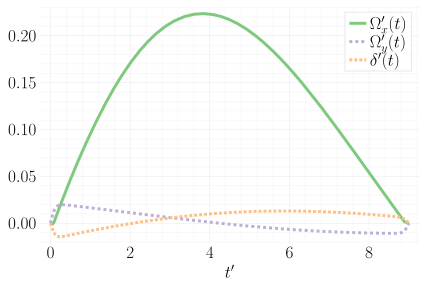

In [79]:
function Ωxy(t,p)
    envelope = smooth_square_envelope(t);
    nn_output = Ωp_nn([t/T],p);
    @inbounds Ωx, Ωy, δ = envelope*nn_output[1]*sin(nn_output[2]), 
    envelope*nn_output[3]*sin(nn_output[4]), 
    envelope*nn_output[5]*sin(nn_output[6])
    return [Ωx, Ωy, δ]
end

const fonstsize = 18;
theme(:bright)

Plots.plot( τ -> 2*Ωxy(τ / (abs(Δ)/(2π)), 
        transmon_nn_solution)[1]/abs(Δ), 0, T*abs(Δ)/(2π), label = L"\Omega'_x(t)", lw=3, 
    xlabel = L"t'", 
    xtickfont=font(fonstsize-0), 
    ytickfont=font(fonstsize-0),
    guidefont=font(fonstsize-0), 
    legendfont=font(fonstsize-0), 
    palette = :Accent_8, legend = :topright) 
Plots.plot!(τ -> 2*Ωxy(τ/(abs(Δ)/(2π)), 
        transmon_nn_solution)[2]/abs(Δ), 0, T*abs(Δ)/(2π), 
    label = L"\Omega'_y(t)", lw=3, line=:dash)
Plots.plot!(τ -> Ωxy(τ/(abs(Δ)/(2π)),   
        transmon_nn_solution)[3]/abs(Δ), 0, T*abs(Δ)/(2π), 
    label = L"\delta'(t)",   lw=3, line=:dashdot)

In [80]:
savefig("transmon-pulse.pdf")